# Anvendt Programmering

## Lektion 7: PPG og Feature Engineering

**Biomedical Engineering**

**Martin Siemienski Andersen**



# Overblik (i dag)

- Vi arbejder med PPG og **Feature**‑udtræk
- Vi går fra rå tidsserie → beats → **Feature**‑tabel
- Vi afslutter med at præsentere og fortolke resultater (variation/usikkerhed)

**Hvorfor skal vi kunne det?**
- Fordi det ofte er **Features** vi rent faktisk vil vide noget om (fx puls, variation, amplitude, rise time)
- Fordi det er sådan man gør signaler sammenlignelige og klar til statistik/ML/QA
- Fordi gode **Feature**‑mål giver et enkelt, målbart svar på et fysiologisk spørgsmål


# Etik: hvorfor gemme Features istedet for en tidsserie

## Idéen
- Rå biosignaler kan rumme mere information end nødvendigt for formålet (og kan være følsomme).
- **Feature**‑tabeller er ofte tilstrækkelige til statistik/ML/QA og kan reducere risiko ved deling og opbevaring.


## Vigtige nuancer
- **Feature** er ikke automatisk anonymisering: afledte data kan stadig være personoplysninger/helbredsoplysninger.
- Valget handler om *formål* og *nødvendighed* — og om at dokumentere hvad du har gjort.

**Referencer (GDPR, EUR‑Lex)**
- Dataminimering: art. 5(1)(c) https://eur-lex.europa.eu/eli/reg/2016/679/oj
- Formålsbegrænsning: art. 5(1)(b) https://eur-lex.europa.eu/eli/reg/2016/679/oj
- Privacy by design: art. 25 https://eur-lex.europa.eu/eli/reg/2016/679/oj
- Sikkerhed ved behandling: art. 32 https://eur-lex.europa.eu/eli/reg/2016/679/oj
- Særlige kategorier (helbredsoplysninger): art. 9 https://eur-lex.europa.eu/eli/reg/2016/679/oj

# Hvad er en Feature? (formelt)

## Definition
- En **Feature** er en funktion $f(\mathbf{x})$ der kortlægger et signal (eller et segment/beat) til et tal:
  $$f: \mathbb{R}^N \to \mathbb{R}$$
- Målet er at opsummere *relevant* information og ignorere resten (støj/irrelevant variation).

## Kvalitetskriterier (tommelregler)
- **Fortolkbar**: kan forklares fysiologisk/teknisk
- **Robust**: ændrer sig ikke voldsomt ved små artefakter/parameterændringer
- **Reproducerbar**: samme data + samme pipeline ⇒ samme tal
- **Brugbar**: hjælper på et konkret spørgsmål (QA, statistik, ML)

## Eksempler i PPG
- Amplitude (peak − baseline/foot)
- Rise time (foot → peak)
- IBI (inter-beat interval) og BPM

# Forskel på en Feature og et Filter

- Et **filter** ændrer et signal for at fremhæve/fjerne bestemte mønstre.
- En **Feature** udtrækker et *tal* (eller få tal) der opsummerer noget relevant i signalet/et beat

## Sammenligning
- **Output**: filter → signal; **Feature** → tal/vektor (Feature‑tabel)
- **Formål**: filter → støjreduktion/separation; **Feature** → måling/opsummering til statistik/ML/QA
- **Matematik**: filtre er ofte lineære/tidsinvariante (LTI); **Feature** er ofte ikke‑lineær (peak, max, threshold, logik)

## Man kan (næsten) sige: “Feature er et informations‑filter”
- En **Feature** “filtrerer information” ved at beholde det vi vil måle og ignorere resten.

## Eksempel (PPG)
- Low‑pass filter: gør pulskurven glattere → lettere peak detection
- **Feature**: amplitude, rise time, IBI/BPM → tal pr. beat der kan sammenlignes og plottes med fx error bars

# Definer det underliggende information fra en waveform


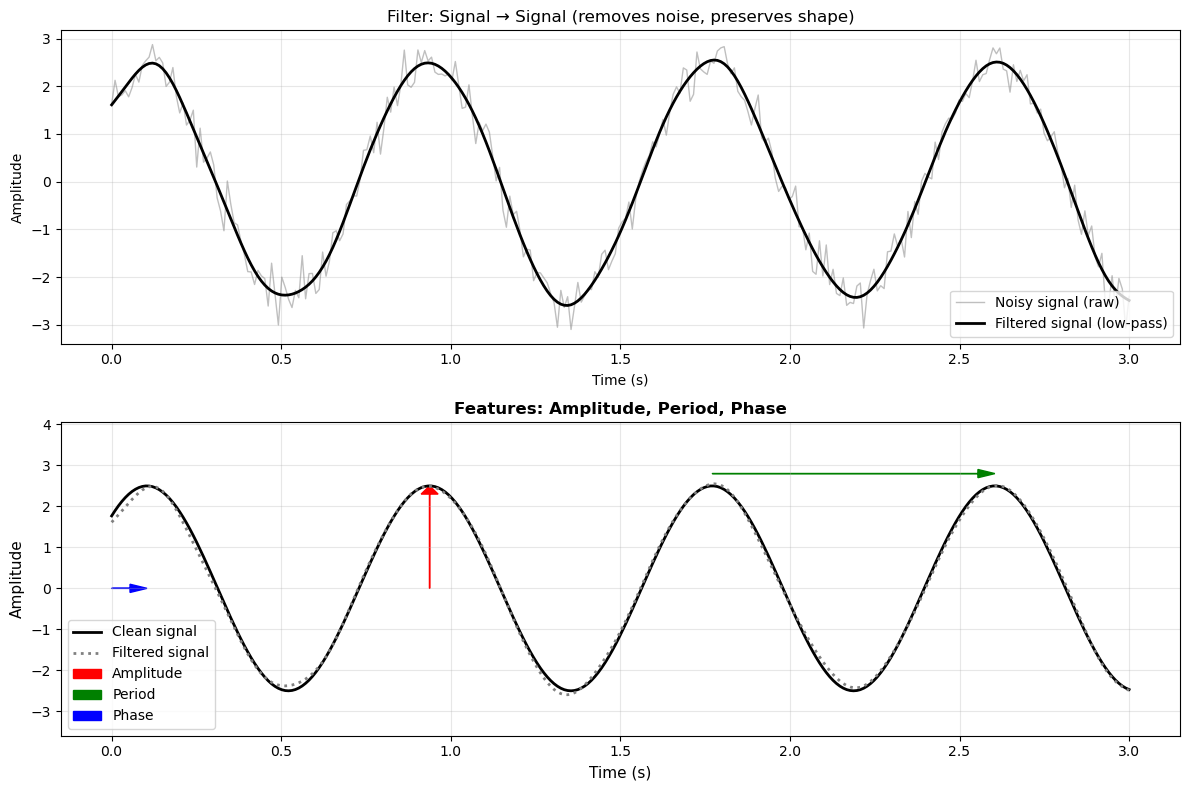

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as scipy_signal

# Generate from features: amplitude, frequency, phase
fs = 100  # sampling frequency (Hz)
t = np.linspace(0, 3, fs * 3)  # 3 seconds
f0 = 1.2  # frequency (Hz)
A = 2.5  # amplitude
phase = np.pi / 4  # phase offset

# Clean signal
clean_signal = A * np.sin(2 * np.pi * f0 * t + phase)
# Add noise
noise = np.random.normal(0, 0.3, len(t))
noisy_signal = clean_signal + noise
# Apply a low-pass filter (Butterworth)
b, a = scipy_signal.butter(4, 5, fs=fs, btype='low')
filtered_signal = scipy_signal.filtfilt(b, a, noisy_signal)
def peak_time(n, f0, phase):
    return (np.pi/2 - phase + n * 2*np.pi) / (2 * np.pi * f0)



# Visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Top plot: Filter example
axes[0].plot(t, noisy_signal, 'gray', alpha=0.5, linewidth=1, label='Noisy signal (raw)')
axes[0].plot(t, filtered_signal, 'black', linewidth=2, label='Filtered signal (low-pass)')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Filter: Signal → Signal (removes noise, preserves shape)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bottom plot: Feature extraction (improved)
axes[1].plot(t, clean_signal, 'black', linewidth=2, label='Clean signal')
axes[1].plot(t, filtered_signal, 'gray', linewidth=2,linestyle=":", label='Filtered signal')
axes[1].arrow(peak_time(1, f0, phase), 0, 0, A,
               head_width=0.05, head_length=0.2, fc='red', ec='red', length_includes_head=True, label='Amplitude')
axes[1].arrow(peak_time(2, f0, phase), A+0.3, 1/f0, 0,
               head_width=0.2, head_length=0.05, fc='green', ec='green', length_includes_head=True, label='Period', )
axes[1].arrow(0, 0, peak_time(0, f0, phase), 0,
               head_width=0.2, head_length=0.05, fc='blue', ec='blue', length_includes_head=True, label='Phase')

axes[1].set_xlabel('Time (s)', fontsize=11)
axes[1].set_ylabel('Amplitude', fontsize=11)
axes[1].set_title('Features: Amplitude, Period, Phase', fontsize=12, weight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_ylim([np.min(filtered_signal) - 1, np.max(filtered_signal) + 1.5])

plt.tight_layout()
plt.show()


# Fra signal til Feature‑tabel

## Struktur
- Én række pr. beat (eller pr. tidsvindue)
- Kolonner = **Feature**‑mål + evt. kvalitet/flag

## Eksempel på kolonner (beat‑niveau)
- `t_peak_s` (tidspunkt)
- `ibi_s` (inter-beat interval)
- `bpm`
- `amp_au` (amplitude)
- `rise_time_s`
- `qc_flag` (fx motion/clipping)

## Hvorfor tabellen er vigtig
- Gør det nemt at lave `describe()`, plots, grupperinger og sammenligninger
- Gør det muligt at vise variation (fx pr. person eller før/efter)

# Variation og “error bars” (hvordan og hvordan man læser dem)

## Hvad viser error bars?
- Error bars viser *variation* eller *usikkerhed* omkring et tal (typisk et gennemsnit).
- Vigtigt: man skal altid sige hvad de betyder (ellers kan de misforstås).

## Typiske valg
- **Standardafvigelse (SD)**: spredning i dine målinger (hvor variable beats/personer er).
- **Standard error (SEM)**: usikkerhed på middelværdien ($\mathrm{SEM}=\mathrm{SD}/\sqrt{n}$).
- **95% konfidensinterval (CI)**: interval for middelværdien (ofte $\bar{x} \pm 1.96\cdot \mathrm{SEM}$ ved stor $n$).

## Hvordan fortolker man det
- SD: “hvor meget varierer data?”
- SEM/CI: “hvor præcist har vi estimeret middelværdien?”
- Overlap af error bars er **ikke** en sikker test for signifikans, men kan give et hurtigt visuelt hint.

## God praksis
- Vis også datapunkter/fordeling (scatter, histogram, boxplot) når det er muligt
- Brug median + IQR hvis fordelingen er skæv eller der er outliers